In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
import os
from ast import literal_eval
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras import layers, models

import fastestimator as fe
from fastestimator.op import TensorOp
from fastestimator.op.numpyop import Minmax
from fastestimator.trace.io import ModelSaver
from fastestimator.util.compute_overlap import compute_overlap

In [3]:
WIDTH = 512
HEIGHT = 512
num_classes = 12+1

### Load SVHN data set

#### Once this is done we will use COCO data set.

In [4]:
from fastestimator.dataset import coco

In [5]:
# train_csv, test_csv, path = coco.load_data('/home/ubuntu/coco')
path = '/home/ubuntu/coco'
train_csv = os.path.join(path,'train_new.csv')
test_csv = os.path.join(path, 'val_new.csv')

In [6]:
import pandas as pd
df = pd.read_csv(train_csv)
# df = pd.read_csv(test_csv)

# df.head()

# df['label']=df['label_new']
# # df.to_csv('/home/ubuntu/coco/train_new.csv', index=False)
# df.to_csv('/home/ubuntu/coco/val_new.csv', index=False)

# df.head()

### Create a smaller data set

#### TFRecords generation at high resolution (800x1280) is super slow. I am creating a smaller data set.

In [7]:
# train = pd.read_csv(train_csv)
# test = pd.read_csv(test_csv)

# train_small = train[0:3000]
# train_small.to_csv(os.path.join(path,'train_small.csv'), index=False)
# test_small = test[0:50]
# test_small.to_csv(os.path.join(path,'test_small.csv'),index=False)
                   

### Plot image and bounding box
#### Note: I found that 30.png, 18522.png are not correct.

In [8]:
index = 900

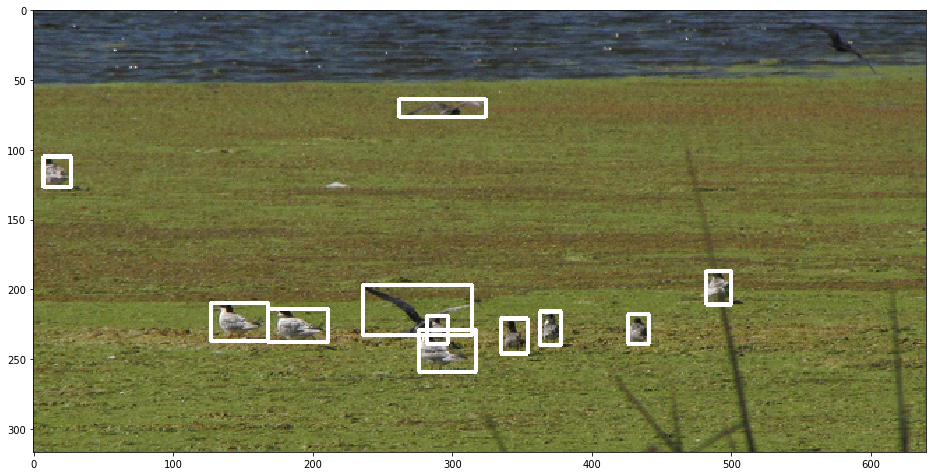

In [9]:
im = cv2.imread(os.path.join(path, df['image'][index]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,16))
# fig, ax = plt.subplots()
for box_index in range(len(literal_eval(df['label'][index]))):
    x1 = literal_eval(df['x1'][index])[box_index]
    y1 = literal_eval(df['y1'][index])[box_index]
    x2 = literal_eval(df['x2'][index])[box_index]
    y2 = literal_eval(df['y2'][index])[box_index]
    cv2.rectangle(im, (x1, y1), (x2, y2), (255, 255, 255), 2)
    
plt.imshow(im)
# df.loc[index]

### Create tfrecord writer

In [10]:
from fastestimator.op import NumpyOp
from fastestimator.op.numpyop import ImageReader, Minmax, Resize
from fastestimator.util import RecordWriter

In [11]:
class String2List(NumpyOp):
    # this thing converts '[1, 2, 3]' into np.array([1, 2, 3])
    def forward(self, data, state):
        data = map(literal_eval, data)
        return data

In [12]:
class GenerateTarget(NumpyOp):
    def __init__(self, inputs=None, outputs=None, mode=None, input_shape=(800, 800, 3)):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.pyramid_levels = [3, 4, 5, 6, 7]
        self.sizes = [32, 64, 128, 256, 512]
        self.strides = [8, 16, 32, 64, 128]
        self.ratios = np.array([0.5, 1, 2], dtype=np.float)
        self.scales = np.array([2**0, 2**(1.0 / 3.0), 2**(2.0 / 3.0)], dtype=np.float)

        self.anchors_list = np.zeros((0, 4))
        image_shapes = [(np.array(input_shape[:2]) + 2**pyra_level - 1) // (2**pyra_level)
                        for pyra_level in self.pyramid_levels]
        for idx, pyra_level in enumerate(self.pyramid_levels):
            base_size = self.sizes[idx]
            ratios = self.ratios
            scales = self.scales
            image_shape = image_shapes[idx]
            strides = self.strides[idx]
            anchors = self.generate_anchors_core(base_size, ratios, scales)
            shifted_anchors = self.shift(image_shape, strides, anchors)
            self.anchors_list = np.append(self.anchors_list, shifted_anchors, axis=0)

    def forward(self, data, state):
        label, x1, y1, x2, y2, image = data
        target_cls, target_loc = self.get_target(self.anchors_list, label, x1, y1, x2, y2, num_classes= num_classes) # 10 classes + bg
        return target_cls, target_loc, self.anchors_list

    def get_target(self, anchorbox, label, x1, y1, x2, y2, num_classes= num_classes):  # this is 80 not 81
        bg_index = num_classes - 1
        query_box = np.zeros((0, 4))
        query_label = np.zeros((0))
        for _x1, _y1, _x2, _y2, _label in zip(x1, y1, x2, y2, label):
            query_box = np.append(query_box, np.array([[_x1, _y1, _x2, _y2]]), axis=0)
            query_label = np.append(query_label, _label)

        overlap = compute_overlap(anchorbox.astype(np.float64), query_box.astype(np.float64))
        
        gt_argmax_overlaps_inds = np.argmax(overlap, axis=0)
        gt_max_overlaps = np.max(overlap, axis=0)
        for i,(elem_gt_argmax_overlap_ind, elem_gt_max_overlap) in enumerate(zip(gt_argmax_overlaps_inds, gt_max_overlaps)):
            overlap[elem_gt_argmax_overlap_ind, i]=1.0
            
        
        argmax_overlaps_inds = np.argmax(overlap, axis=1)
        max_overlaps = overlap[np.arange(overlap.shape[0]), argmax_overlaps_inds]
        positive_index = (max_overlaps > 0.5)
        ignore_index = (max_overlaps > 0.4) & ~positive_index
        negative_index = (max_overlaps <= 0.4)

        target_loc = get_loc_offset(query_box[argmax_overlaps_inds, :], anchorbox)
        target_cls = query_label[argmax_overlaps_inds]
        target_cls[negative_index] = bg_index
        target_cls[ignore_index] = -2  # ignore this example

        return target_cls, target_loc

    def generate_anchors_core(self, base_size, ratios, scales):
        num_anchors = len(ratios) * len(scales)
        # initialize output anchors
        anchors = np.zeros((num_anchors, 4))
        # scale base_size
        anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T

        # compute areas of anchors
        areas = anchors[:, 2] * anchors[:, 3]

        # correct for ratios
        anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
        anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))

        # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
        anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
        anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

        return anchors

    def shift(self, image_shape, stride, anchors):
        shift_x = (np.arange(0, image_shape[1]) + 0.5) * stride
        shift_y = (np.arange(0, image_shape[0]) + 0.5) * stride
        shift_x, shift_y = np.meshgrid(shift_x, shift_y)

        shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel())).transpose()

        A = anchors.shape[0]
        K = shifts.shape[0]
        all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
        all_anchors = all_anchors.reshape((K * A, 4))

        return all_anchors

In [13]:
class ResizeCocoStyle(Resize):
    def __init__(self, target_size, keep_ratio=False, inputs=None, outputs=None, mode=None):
        super().__init__(target_size, keep_ratio=keep_ratio, inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        img, x1, y1, x2, y2 = data
        pad  = None
        if self.keep_ratio:
            original_ratio = img.shape[1] / img.shape[0]
            target_ratio = self.target_size[1] / self.target_size[0]
            if original_ratio >= target_ratio:
                pad = (img.shape[1] / target_ratio - img.shape[0]) / 2
                pad_boarder = (np.ceil(pad).astype(np.int), np.floor(pad).astype(np.int), 0, 0)
                y1 += np.ceil(pad).astype(np.int)
                y2 += np.ceil(pad).astype(np.int)
            else:
                pad = (img.shape[0] * target_ratio - img.shape[1]) / 2
                pad_boarder = (0, 0, np.ceil(pad).astype(np.int), np.floor(pad).astype(np.int))
                x1 += np.ceil(pad).astype(np.int)
                x2 += np.ceil(pad).astype(np.int)

            img = cv2.copyMakeBorder(img, *pad_boarder, cv2.BORDER_CONSTANT)
            padimg_targimg_ratio = np.array([ img.shape[1]/self.target_size[1],
                                            img.shape[0]/self.target_size[0],
                                            img.shape[1]/self.target_size[1],
                                            img.shape[0]/self.target_size[0]], dtype=np.float)
           
        padding = np.array([pad_boarder[2], pad_boarder[0] ,pad_boarder[2], pad_boarder[0]])
        img_resize = cv2.resize(img, (self.target_size[1], self.target_size[0]), self.resize_method)
        x1 = (np.array(x1) * self.target_size[1] / img.shape[1]).astype(np.int64)
        x2 = (np.array(x2) * self.target_size[1] / img.shape[1]).astype(np.int64)
        y1 = (np.array(y1) * self.target_size[0] / img.shape[0]).astype(np.int64)
        y2 = (np.array(y2) * self.target_size[0] / img.shape[0]).astype(np.int64)
        return img_resize, x1, y1, x2, y2, padding, padimg_targimg_ratio

### Util functions

In [14]:
def get_loc_offset(box_gt, box_anchor):
    mean = 0
    std = 0.2
    anchor_width_height = np.tile(box_anchor[:, 2:] - box_anchor[:, :2], [1, 2])
    delta = (box_gt - box_anchor) / anchor_width_height
    return (delta -mean) / std

### Record writer

In [15]:
writer = RecordWriter(
    train_data=os.path.join(path, 'train_new.csv'),
    validation_data=os.path.join(path, 'val_new.csv'),
    save_dir=os.path.join(path, 'tfrecords'),
    ops=[
        ImageReader(inputs='image', outputs='image', parent_path=path),
        String2List(inputs=["label", "x1", "y1", "x2", "y2"], outputs=["label", "x1", "y1", "x2", "y2"]),
        ResizeCocoStyle((HEIGHT, WIDTH),
                        keep_ratio=True,
                        inputs=["image", "x1", "y1", "x2", "y2"],
                        outputs=["image", "x1", "y1", "x2", "y2", "padding", "padimg_targimg_ratio"]),
        Minmax(inputs="image", outputs="image"),
        GenerateTarget(inputs=["label", "x1", "y1", "x2", "y2", "image"],
                       outputs=["target_cls", "target_loc", "base_loc"],
                       input_shape=(HEIGHT, WIDTH, 3))
    ])

### Pipeline

In [16]:
pipeline = fe.Pipeline(data=writer, batch_size=8, padded_batch=True, read_feature=["image", "image_id", "target_cls", "target_loc","base_loc",
                                                                                   "padding","padimg_targimg_ratio"])
# pipeline = fe.Pipeline(data=writer, batch_size=8, padded_batch=True, read_feature=["image", "image_id","x1","x2","y1","y2","orig_img_shape",
#                                                                                    "pad_img_shape","padding","padded_target_ratio"])

In [17]:
# !rm -rf /home/ubuntu/coco/tfrecords/

In [18]:
batch_data = pipeline.show_results(mode='train', num_steps=5)

FastEstimator: Reading non-empty directory: /home/ubuntu/coco/tfrecords
FastEstimator: Found 5938 examples for train in /home/ubuntu/coco/tfrecords/train_summary0.json
FastEstimator: Found 2985 examples for eval in /home/ubuntu/coco/tfrecords/eval_summary0.json


In [19]:
batch_data[0].keys()

dict_keys(['image', 'image_id', 'target_cls', 'target_loc', 'base_loc', 'padding', 'padimg_targimg_ratio'])

In [20]:
# idx = np.random.randint(0,5)
# # idx =4
# print('idx:',idx)
# batch_index = np.random.randint(0,8)
# print('batch_index:',batch_index)
# # batch_index = 1
# im = batch_data[idx]['image'].numpy()[batch_index]
# shape_o = batch_data[idx]['orig_img_shape'].numpy()[batch_index]
# shape_p = batch_data[idx]['pad_img_shape'].numpy()[batch_index]
# pad = batch_data[idx]['padding'].numpy()[batch_index]
# pad_targ_ratio = batch_data[idx]['padded_target_ratio'].numpy()[batch_index]
# X1 = batch_data[idx]["x1"].numpy()[batch_index]
# Y1 = batch_data[idx]["y1"].numpy()[batch_index]
# X2 = batch_data[idx]["x2"].numpy()[batch_index]
# Y2 = batch_data[idx]["y2"].numpy()[batch_index]

# bb = np.stack([X1,Y1,X2,Y2], axis=1)
# print(bb.shape)
# print(im.shape)
# im2 = cv2.resize(im,(shape_p[1], shape_p[0]))
# print(shape_o, shape_p, im2.shape)
# print(pad)
# crp_img2 = im2[pad[1]:shape_o[0]+pad[1],pad[0]:shape_o[1]+pad[0]]

# fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(16,16))
# for bb_elem in bb :
#     x1,y1,x2,y2 = bb_elem
#     im = cv2.rectangle(im, (x1, y1), (x2, y2), (255, 255, 255), 3)
#     print(pad_targ_ratio)
#     bb_elem_o = bb_elem*pad_targ_ratio - pad
#     x1,y1,x2,y2 = bb_elem_o
#     x1,y1,x2,y2 = int(x1), int(y1), int(x2), int(y2)
#     crp_img2 = cv2.rectangle(crp_img2, (x1, y1), (x2, y2), (255, 255, 255), 3)
# ax[0].imshow(im)
# ax[1].imshow(crp_img2)

### Keras definitions

#### Classification head

In [21]:
def classification_sub_net(num_classes, num_anchor=9):
    model = models.Sequential()
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(num_classes * num_anchor,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='sigmoid',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer=tf.initializers.constant(np.log(1 / 99))))
    model.add(layers.Reshape((-1, num_classes)))  # the output dimension is [batch, #anchor, #classes]
    return model

### Regression head

In [22]:
def regression_sub_net(num_anchor=9):
    model = models.Sequential()
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(4 * num_anchor,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(layers.Reshape((-1, 4)))  # the output dimension is [batch, #anchor, 4]
    return model


## Define RetinaNet


In [23]:
def RetinaNet(input_shape, num_classes, num_anchor=9):
    inputs = tf.keras.Input(shape=input_shape)
    # FPN
    #     weights = '/home/ubuntu/ResNet-50-model.keras.h5'
    resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=inputs, pooling=None)
    #     resnet50.load_weights(weights, by_name=True)
    assert resnet50.layers[80].name == "conv3_block4_out"
    C3 = resnet50.layers[80].output
    assert resnet50.layers[142].name == "conv4_block6_out"
    C4 = resnet50.layers[142].output
    assert resnet50.layers[-1].name == "conv5_block3_out"
    C5 = resnet50.layers[-1].output
    
    P5 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same')(C5)
    P5_upsampling = layers.UpSampling2D()(P5)
    P4 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same')(C4)
    P4 = layers.Add()([P5_upsampling, P4])
    P4_upsampling = layers.UpSampling2D()(P4)
    P3 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same')(C3)
    
    P3 = layers.Add()([P4_upsampling, P3])
    
    P6 = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', name="P6")(C5)
    P7 = layers.Activation('relu')(P6)
    P7 = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', name="P7")(P7)
    P5 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name="P5")(P5)
    P4 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name="P4")(P4)
    P3 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name="P3")(P3)
    # classification subnet
    cls_subnet = classification_sub_net(num_classes=num_classes, num_anchor=num_anchor)
    P3_cls = cls_subnet(P3)
    P4_cls = cls_subnet(P4)
    P5_cls = cls_subnet(P5)
    P6_cls = cls_subnet(P6)
    P7_cls = cls_subnet(P7)
    cls_output = layers.Concatenate(axis=-2)([P3_cls, P4_cls, P5_cls, P6_cls, P7_cls])
    # localization subnet
    loc_subnet = regression_sub_net(num_anchor=num_anchor)
    P3_loc = loc_subnet(P3)
    P4_loc = loc_subnet(P4)
    P5_loc = loc_subnet(P5)
    P6_loc = loc_subnet(P6)
    P7_loc = loc_subnet(P7)
    loc_output = layers.Concatenate(axis=-2)([P3_loc, P4_loc, P5_loc, P6_loc, P7_loc])
    return tf.keras.Model(inputs=inputs, outputs=[cls_output, loc_output])

## Define loss

In [24]:
from fastestimator.op.tensorop import Loss

In [25]:
class RetinaLoss(Loss):
    def focal_loss(self, cls_gt_example, cls_pred_example, num_classes, alpha=0.25, gamma=2.0):
        bg_index = num_classes - 1
        # cls_gt has shape [A], cls_pred is in [A, K]
        # gather the objects and background, discard the rest
        obj_idx = tf.where(tf.logical_and(tf.greater_equal(cls_gt_example, 0), tf.less(cls_gt_example, bg_index)))
        obj_bg_idx = tf.where(tf.greater_equal(cls_gt_example, 0))
        obj_bg_count = tf.cast(tf.shape(obj_bg_idx)[0], tf.float32)
        obj_count = tf.cast(tf.maximum(tf.shape(obj_idx)[0], 1), tf.float32)
        cls_gt_example = tf.one_hot(cls_gt_example, num_classes)
        cls_gt_example = tf.gather_nd(cls_gt_example, obj_bg_idx)
        cls_pred_example = tf.gather_nd(cls_pred_example, obj_bg_idx)
        cls_gt_example = tf.reshape(cls_gt_example, (-1, 1))
        cls_pred_example = tf.reshape(cls_pred_example, (-1, 1))
        # compute the focal weight on each selected anchor box
        alpha_factor = tf.ones_like(cls_gt_example) * alpha
        alpha_factor = tf.where(tf.equal(cls_gt_example, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = tf.where(tf.equal(cls_gt_example, 1), 1 - cls_pred_example, cls_pred_example)
        focal_weight = alpha_factor * focal_weight**gamma / obj_count
        cls_loss = tf.losses.BinaryCrossentropy(reduction='sum')(cls_gt_example,
                                                                 cls_pred_example,
                                                                 sample_weight=focal_weight)
        return cls_loss

    def smooth_l1(self, loc_gt_example, loc_pred_example, cls_gt_example, cls_pred_example, num_classes):
        # loc_gt anf loc_pred has shape [A, 4]
        bg_index = num_classes - 1
        obj_idx = tf.where(tf.logical_and(tf.greater_equal(cls_gt_example, 0), tf.less(cls_gt_example, bg_index)))
        sigma = 3
        sigma_squared = sigma**3
        obj_count = tf.cast(tf.maximum(tf.shape(obj_idx)[0], 1), tf.float32)
        loc_gt = tf.gather_nd(loc_gt_example, obj_idx)
        loc_pred = tf.gather_nd(loc_pred_example, obj_idx)
        loc_gt = tf.reshape(loc_gt, (-1, 1))
        loc_pred = tf.reshape(loc_pred, (-1, 1))
        loc_diff = tf.abs(loc_gt - loc_pred)
        smooth_l1_loss = tf.where(tf.less(loc_diff, 1 / sigma_squared),
                                  0.5 * loc_diff**2 * sigma_squared,
                                  loc_diff - 0.5 / sigma_squared)
        smooth_l1_loss = tf.reduce_sum(smooth_l1_loss) / obj_count
        return smooth_l1_loss

    def forward(self, data, state):
        cls_gt, loc_gt, cls_pred, loc_pred = data
        cls_gt = tf.cast(cls_gt, tf.int32)
        batch_size = state["local_batch_size"]
        focal_loss = tf.map_fn(lambda x: self.focal_loss(x[0], x[1], num_classes= num_classes), 
                                        (cls_gt, cls_pred),dtype=tf.float32, back_prop=False)
        smooth_l1_loss = tf.map_fn(lambda x: self.smooth_l1(x[0], x[1], x[2], x[3], num_classes= num_classes),(loc_gt, loc_pred, cls_gt, cls_pred),
                                   dtype=tf.float32, back_prop=False)
        total_loss = tf.add(focal_loss, smooth_l1_loss)
        return total_loss
    


In [26]:
# Not using PredictBox yet

class PredictBox(TensorOp):
    def __init__(self, num_classes, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.num_classes = num_classes
        self.bg_index = num_classes - 1

    def forward(self, data, state):
        cls_pred, loc_pred, loc_base = data
        input_width = WIDTH
        input_height = HEIGHT
        top_n = 300
        score_threshold = 0.05
        std = 0.2
        mean = 0
        # convert the residual prediction to absolute prediction in (x1, y1, x2, y2)
        anchor_w_h = tf.tile(loc_base[:, :, 2:], [1, 1, 2]) - tf.tile(loc_base[:, :, :2], [1, 1, 2])
        anchorbox = loc_base
        loc_pred_abs = tf.map_fn(lambda x: (x[0] * std + mean) * x[1] + x[2],
                                 elems=(loc_pred, anchor_w_h, anchorbox),
                                 dtype=tf.float32,
                                 back_prop=False)
        x1 = tf.clip_by_value(loc_pred_abs[:, :, 0], 0, input_width)
        y1 = tf.clip_by_value(loc_pred_abs[:, :, 1], 0, input_height)
        x2 = tf.clip_by_value(loc_pred_abs[:, :, 2], 0, input_width)
        y2 = tf.clip_by_value(loc_pred_abs[:, :, 3], 0, input_height)
        loc_pred_abs = tf.stack([x1, y1, x2, y2], axis=2)

        num_batch, num_anchor, _ = loc_pred_abs.shape
        cls_best_score = tf.reduce_max(cls_pred, axis=-1)
        cls_best_class = tf.argmax(cls_pred, axis=-1)

        cls_best_score = tf.where(tf.not_equal(cls_best_class, self.bg_index), cls_best_score, 0)

        # select top n anchor boxes to proceed
        # Padded Nonmax suppression with threshold
        selected_indices_padded = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).selected_indices,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
        valid_outputs = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).valid_outputs,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
        
        return loc_pred_abs, selected_indices_padded, valid_outputs

## Create network

In [27]:
from fastestimator.op.tensorop.model import ModelOp

# prepare model
model = fe.build(model_def=lambda: RetinaNet(input_shape=(HEIGHT, WIDTH, 3), num_classes= num_classes),
                 model_name="retinanet",
                 optimizer=tf.optimizers.Adam(learning_rate=0.00001),
                 loss_name="loss")

network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs=["pred_cls", "pred_loc"]),
    PredictBox(num_classes, inputs=["pred_cls","pred_loc","base_loc"], outputs=("abs_loc","selected_indices_padded", "valid_outputs"), mode="eval"),
    RetinaLoss(inputs=("target_cls", "target_loc", "pred_cls", "pred_loc"), outputs="loss"),
])


### Create estimator

In [28]:
6000/32

187.5

In [29]:
from fastestimator.trace.adapt.lr_controller import LRController
from fastestimator.trace.metric.coco_mean_avg_precision import MeanAveragePrecision

# prepare estimator
model_dir = '/home/ubuntu/coco/bestmodel'
traces = [
    MeanAveragePrecision('selected_indices_padded','valid_outputs','image_id','pred_cls', 'abs_loc',
                         'padimg_targimg_ratio', 'padding', coco_path='/home/ubuntu/coco', val_csv='val_new.csv'),
    LRController(model_name="retinanet", reduce_on_eval=True, reduce_patience=18, reduce_factor=0.5, min_lr=1e-08),
    ModelSaver(model_name="retinanet", save_dir=model_dir, save_best=True)
]
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=300,
                         steps_per_epoch=85,
                         log_steps=5,
                         traces=traces)

loading annotations into memory...
Done (t=4.95s)
creating index...
index created!


In [ ]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator: Reading non-empty directory: /home/ubuntu/coco/tfrecords
FastEstimator: Found 5938 examples for train in /home/ubuntu/coco/tfrecords/train_summary0.json
FastEstimator: Found 2985 examples for eval in /home/ubuntu/coco/tfrecords/eval_summary0.json
FastEstimator-Start: step: 0; total_train_steps: 25500; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 0; loss: 3498.3743; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5; loss: 1147.5342; examples/sec: 37.1; progress: 0.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10; loss: 8160.1445;

FastEstimator-Train: step: 265; loss: 16.24276; examples/sec: 19.9; progress: 1.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 270; loss: 15.300517; examples/sec: 20.0; progress: 1.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 275; loss: 14.92017; examples/sec: 20.0; progress: 1.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 280; loss: 14.534006; examples/sec: 18.8; progress: 1.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 285; loss: 15.521715; examples/sec: 18.9; progress: 1.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 290; loss: 15.509231; examples/sec: 19.8; progress: 1.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 295; loss: 14.001131; examples/sec: 18.9; progress: 1.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 300; loss: 15.571241; examples/sec: 19.0; progress: 1.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 305; loss: 13.979914; examples/sec: 19.3; progress: 1.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 310; loss: 1

FastEstimator-Train: step: 605; loss: 11.530045; examples/sec: 18.4; progress: 2.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 610; loss: 14.329745; examples/sec: 18.3; progress: 2.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 615; loss: 11.011107; examples/sec: 18.7; progress: 2.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 620; loss: 11.058989; examples/sec: 17.3; progress: 2.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 625; loss: 13.016517; examples/sec: 18.4; progress: 2.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 630; loss: 10.755121; examples/sec: 18.4; progress: 2.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 635; loss: 10.444561; examples/sec: 19.6; progress: 2.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 640; loss: 11.411219; examples/sec: 20.0; progress: 2.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 645; loss: 9.455279; examples/sec: 20.1; progress: 2.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 650; loss: 

FastEstimator-Train: step: 945; loss: 7.297183; examples/sec: 19.0; progress: 3.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 950; loss: 8.016916; examples/sec: 19.3; progress: 3.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 955; loss: 7.939633; examples/sec: 19.8; progress: 3.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 960; loss: 7.6266074; examples/sec: 18.6; progress: 3.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 965; loss: 7.4045305; examples/sec: 21.5; progress: 3.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 970; loss: 7.371228; examples/sec: 29.7; progress: 3.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 975; loss: 8.378309; examples/sec: 29.6; progress: 3.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 980; loss: 7.479644; examples/sec: 25.4; progress: 3.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 985; loss: 8.611952; examples/sec: 28.5; progress: 3.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 990; loss: 7.7246

FastEstimator-Train: step: 1280; loss: 6.006709; examples/sec: 33.5; progress: 5.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1285; loss: 5.4665976; examples/sec: 21.2; progress: 5.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1290; loss: 4.8048725; examples/sec: 18.5; progress: 5.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1295; loss: 6.107108; examples/sec: 20.9; progress: 5.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1300; loss: 5.8496256; examples/sec: 19.9; progress: 5.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1305; loss: 5.848037; examples/sec: 20.2; progress: 5.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1310; loss: 5.303113; examples/sec: 20.4; progress: 5.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1315; loss: 5.1864247; examples/sec: 20.6; progress: 5.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1320; loss: 5.371008; examples/sec: 20.7; progress: 5.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1325; 

FastEstimator-Train: step: 1615; loss: 4.641697; examples/sec: 37.2; progress: 6.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1620; loss: 4.027599; examples/sec: 35.4; progress: 6.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1625; loss: 4.2504897; examples/sec: 33.8; progress: 6.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1630; loss: 4.5375757; examples/sec: 28.1; progress: 6.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1635; loss: 3.9966335; examples/sec: 26.5; progress: 6.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1640; loss: 4.7492447; examples/sec: 23.5; progress: 6.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1645; loss: 4.636674; examples/sec: 22.4; progress: 6.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1650; loss: 4.7815022; examples/sec: 23.1; progress: 6.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1655; loss: 4.5883446; examples/sec: 23.4; progress: 6.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1660

FastEstimator-Train: step: 1955; loss: 3.7676067; examples/sec: 22.4; progress: 7.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1960; loss: 4.073018; examples/sec: 33.5; progress: 7.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1965; loss: 4.9290524; examples/sec: 20.8; progress: 7.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1970; loss: 4.514658; examples/sec: 20.5; progress: 7.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1975; loss: 5.3811417; examples/sec: 19.0; progress: 7.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1980; loss: 4.3183727; examples/sec: 20.8; progress: 7.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1985; loss: 3.88616; examples/sec: 21.1; progress: 7.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1990; loss: 4.784777; examples/sec: 21.4; progress: 7.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 1995; loss: 5.4691353; examples/sec: 21.2; progress: 7.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2000; 

FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 2210; epoch: 25; loss: 4.221733; min_loss: 4.221733; since_best_loss: 0; 
FastEstimator-Train: step: 2210; loss: 3.5758865; examples/sec: 37.6; progress: 8.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2215; loss: 3.4370484; examples/sec: 35.8; progress: 8.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2220; loss: 5.2043056; examples/sec: 35.8; progress: 8.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2225; loss: 3.7647004; examples/sec: 3.9; progress: 8.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2230; loss: 4.1563764; examples/sec: 33.8; progress: 8.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2235; loss: 4.059565; examples/sec: 35.2; progress: 8.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2240; loss: 3.9247515; examples/sec: 31.0; progress: 8.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2245; loss: 3.797248; exam

FastEstimator-Train: step: 2455; loss: 3.575664; examples/sec: 34.7; progress: 9.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2460; loss: 3.8274157; examples/sec: 34.8; progress: 9.6%; retinanet_lr: 1e-05; 
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.038
 Average Reca

FastEstimator-Train: step: 2645; loss: 4.2750382; examples/sec: 19.6; progress: 10.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2650; loss: 3.8482397; examples/sec: 19.4; progress: 10.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2655; loss: 3.012688; examples/sec: 19.6; progress: 10.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2660; loss: 3.6517725; examples/sec: 20.0; progress: 10.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2665; loss: 3.611689; examples/sec: 20.2; progress: 10.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2670; loss: 3.8336384; examples/sec: 20.6; progress: 10.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2675; loss: 4.265855; examples/sec: 20.8; progress: 10.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2680; loss: 3.1717238; examples/sec: 21.2; progress: 10.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 2685; loss: 3.3471437; examples/sec: 20.9; progress: 10.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: s

DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

FastEstimator-Train: step: 3090; loss: 3.040348; examples/sec: 20.9; progress: 12.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3095; loss: 3.534828; examples/sec: 26.0; progress: 12.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3100; loss: 4.6622214; examples/sec: 22.7; progress: 12.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3105; loss: 3.9696124; examples/sec: 23.1; progress: 12.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3110; loss: 3.5198405; examples/sec: 25.2; progress: 12.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3115; loss: 4.13113; examples/sec: 25.4; progress: 12.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3120; loss: 2.9858084; examples/sec: 27.3; progress: 12.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3125; loss: 3.4628527; examples/sec: 22.9; progress: 12.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3130; loss: 3.94544; examples/sec: 25.2; progress: 12.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step

FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 3315; epoch: 38; loss: 3.6774; min_loss: 3.6773999; since_best_loss: 0; 
FastEstimator-Train: step: 3315; loss: 3.3763947; examples/sec: 25.7; progress: 13.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3320; loss: 3.5024855; examples/sec: 35.5; progress: 13.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3325; loss: 4.991861; examples/sec: 23.1; progress: 13.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3330; loss: 3.5794487; examples/sec: 20.4; progress: 13.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3335; loss: 3.6633909; examples/sec: 19.0; progress: 13.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3340; loss: 2.9549541; examples/sec: 19.8; progress: 13.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3345; loss: 4.050714; examples/sec: 19.9; progress: 13.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3350; loss: 4.276957

FastEstimator-Train: step: 3560; loss: 2.8992534; examples/sec: 21.0; progress: 14.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3565; loss: 2.9693706; examples/sec: 20.7; progress: 14.0%; retinanet_lr: 1e-05; 
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.82s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.034
 Average R

FastEstimator-Train: step: 3755; loss: 3.2994194; examples/sec: 34.6; progress: 14.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3760; loss: 3.64611; examples/sec: 29.0; progress: 14.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3765; loss: 3.65803; examples/sec: 25.2; progress: 14.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3770; loss: 3.9676156; examples/sec: 26.3; progress: 14.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3775; loss: 3.37192; examples/sec: 26.7; progress: 14.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3780; loss: 3.7419157; examples/sec: 32.9; progress: 14.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3785; loss: 3.5440533; examples/sec: 34.2; progress: 14.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3790; loss: 3.535277; examples/sec: 35.1; progress: 14.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 3795; loss: 3.5616553; examples/sec: 35.1; progress: 14.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step:

FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 3995; epoch: 46; loss: 3.44397; min_loss: 3.44397; since_best_loss: 0; 
FastEstimator-Train: step: 3995; loss: 4.116227; examples/sec: 22.8; progress: 15.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4000; loss: 2.7261653; examples/sec: 35.4; progress: 15.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4005; loss: 3.07987; examples/sec: 23.5; progress: 15.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4010; loss: 3.5560093; examples/sec: 24.1; progress: 15.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4015; loss: 3.3347495; examples/sec: 23.8; progress: 15.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4020; loss: 3.0684872; examples/sec: 22.5; progress: 15.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4025; loss: 3.4495149; examples/sec: 21.0; progress: 15.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4030; loss: 2.9798145;

FastEstimator-Train: step: 4240; loss: 3.639686; examples/sec: 19.0; progress: 16.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4245; loss: 2.9727092; examples/sec: 19.4; progress: 16.6%; retinanet_lr: 1e-05; 
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.95s).
Accumulating evaluation results...
DONE (t=0.35s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.043
 Average Re

FastEstimator-Train: step: 4435; loss: 2.7733912; examples/sec: 35.8; progress: 17.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4440; loss: 2.542092; examples/sec: 35.8; progress: 17.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4445; loss: 2.816392; examples/sec: 35.6; progress: 17.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4450; loss: 4.328983; examples/sec: 35.7; progress: 17.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4455; loss: 3.1920614; examples/sec: 3.8; progress: 17.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4460; loss: 3.9025412; examples/sec: 35.0; progress: 17.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4465; loss: 2.7647643; examples/sec: 34.6; progress: 17.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4470; loss: 2.5652359; examples/sec: 34.9; progress: 17.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4475; loss: 2.8535595; examples/sec: 31.9; progress: 17.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: st

FastEstimator-Train: step: 4675; loss: 3.1267416; examples/sec: 25.6; progress: 18.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4680; loss: 2.3518815; examples/sec: 32.6; progress: 18.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4685; loss: 3.1805282; examples/sec: 20.2; progress: 18.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4690; loss: 3.137046; examples/sec: 20.5; progress: 18.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4695; loss: 2.9585044; examples/sec: 20.2; progress: 18.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4700; loss: 2.9680557; examples/sec: 20.3; progress: 18.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4705; loss: 3.7921703; examples/sec: 20.8; progress: 18.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4710; loss: 2.9189596; examples/sec: 19.9; progress: 18.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 4715; loss: 3.1367083; examples/sec: 19.2; progress: 18.5%; retinanet_lr: 1e-05; 
FastEstimator-Train:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.05s).
Accumulating evaluation results...
DONE (t=0.36s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.051
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

FastEstimator-Train: step: 5125; loss: 2.4460592; examples/sec: 18.4; progress: 20.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5130; loss: 2.088547; examples/sec: 18.8; progress: 20.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5135; loss: 2.8006334; examples/sec: 19.1; progress: 20.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5140; loss: 2.7542825; examples/sec: 20.7; progress: 20.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5145; loss: 3.134761; examples/sec: 20.0; progress: 20.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5150; loss: 2.178684; examples/sec: 19.4; progress: 20.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5155; loss: 3.3081079; examples/sec: 18.2; progress: 20.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5160; loss: 3.349192; examples/sec: 33.0; progress: 20.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5165; loss: 2.8894453; examples/sec: 35.8; progress: 20.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: st

FastEstimator-Train: step: 5355; loss: 3.364006; examples/sec: 31.6; progress: 21.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5360; loss: 3.0107665; examples/sec: 35.3; progress: 21.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5365; loss: 2.744782; examples/sec: 30.7; progress: 21.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5370; loss: 3.7598288; examples/sec: 26.9; progress: 21.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5375; loss: 2.5681255; examples/sec: 33.9; progress: 21.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5380; loss: 2.5380816; examples/sec: 26.3; progress: 21.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5385; loss: 2.7211013; examples/sec: 29.4; progress: 21.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5390; loss: 2.5726662; examples/sec: 27.4; progress: 21.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5395; loss: 2.3325438; examples/sec: 26.6; progress: 21.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: 

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.44s).
Accumulating evaluation results...
DONE (t=0.44s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.023
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

FastEstimator-Train: step: 5805; loss: 2.3988128; examples/sec: 18.9; progress: 22.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5810; loss: 3.0759177; examples/sec: 17.9; progress: 22.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5815; loss: 3.2988944; examples/sec: 18.9; progress: 22.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5820; loss: 2.3357918; examples/sec: 18.4; progress: 22.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5825; loss: 2.7839851; examples/sec: 16.7; progress: 22.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5830; loss: 2.6613204; examples/sec: 17.5; progress: 22.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5835; loss: 3.074905; examples/sec: 17.7; progress: 22.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5840; loss: 2.7679145; examples/sec: 18.4; progress: 22.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 5845; loss: 3.375769; examples/sec: 17.9; progress: 22.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: 

FastEstimator-Train: step: 6035; loss: 2.4630997; examples/sec: 34.0; progress: 23.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6040; loss: 2.3041005; examples/sec: 34.9; progress: 23.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6045; loss: 3.2112074; examples/sec: 35.2; progress: 23.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6050; loss: 2.7417111; examples/sec: 29.2; progress: 23.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6055; loss: 2.454434; examples/sec: 23.7; progress: 23.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6060; loss: 2.2859027; examples/sec: 27.1; progress: 23.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6065; loss: 2.1348443; examples/sec: 23.1; progress: 23.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6070; loss: 1.9247622; examples/sec: 26.4; progress: 23.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6075; loss: 2.2947073; examples/sec: 25.0; progress: 23.8%; retinanet_lr: 1e-05; 
FastEstimator-Train:

DONE (t=1.98s).
Accumulating evaluation results...
DONE (t=0.51s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

FastEstimator-Train: step: 6490; loss: 2.5748937; examples/sec: 20.8; progress: 25.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6495; loss: 2.4504845; examples/sec: 20.2; progress: 25.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6500; loss: 2.480135; examples/sec: 20.7; progress: 25.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6505; loss: 3.0481663; examples/sec: 20.9; progress: 25.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6510; loss: 3.1262314; examples/sec: 19.9; progress: 25.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6515; loss: 2.8495004; examples/sec: 19.6; progress: 25.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6520; loss: 2.3340285; examples/sec: 19.6; progress: 25.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6525; loss: 1.8411348; examples/sec: 19.2; progress: 25.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6530; loss: 2.3132746; examples/sec: 19.3; progress: 25.6%; retinanet_lr: 1e-05; 
FastEstimator-Train:

FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 6715; epoch: 78; loss: 2.8062737; min_loss: 2.8062737; since_best_loss: 0; 
FastEstimator-Train: step: 6715; loss: 2.4743538; examples/sec: 26.5; progress: 26.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6720; loss: 2.8860607; examples/sec: 31.0; progress: 26.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6725; loss: 2.3446393; examples/sec: 27.4; progress: 26.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6730; loss: 2.576853; examples/sec: 30.3; progress: 26.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6735; loss: 1.8482208; examples/sec: 35.3; progress: 26.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6740; loss: 2.1650927; examples/sec: 35.2; progress: 26.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6745; loss: 2.2084804; examples/sec: 35.6; progress: 26.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6750; loss: 2.59

FastEstimator-Train: step: 6960; loss: 2.1661828; examples/sec: 29.6; progress: 27.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 6965; loss: 2.8274517; examples/sec: 20.9; progress: 27.3%; retinanet_lr: 1e-05; 
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.91s).
Accumulating evaluation results...
DONE (t=0.53s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.064
 Average R

FastEstimator-Train: step: 7155; loss: 2.645104; examples/sec: 21.6; progress: 28.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7160; loss: 2.3771756; examples/sec: 18.4; progress: 28.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7165; loss: 2.5010462; examples/sec: 19.3; progress: 28.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7170; loss: 2.4823446; examples/sec: 18.3; progress: 28.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7175; loss: 2.4640846; examples/sec: 18.1; progress: 28.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7180; loss: 3.0197134; examples/sec: 19.2; progress: 28.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7185; loss: 2.3361194; examples/sec: 18.7; progress: 28.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7190; loss: 2.1334496; examples/sec: 18.1; progress: 28.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7195; loss: 2.259741; examples/sec: 17.9; progress: 28.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: 

FastEstimator-Train: step: 7395; loss: 2.40983; examples/sec: 37.1; progress: 29.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7400; loss: 2.6521306; examples/sec: 35.5; progress: 29.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7405; loss: 2.8536477; examples/sec: 35.7; progress: 29.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7410; loss: 2.406202; examples/sec: 35.7; progress: 29.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7415; loss: 2.3176832; examples/sec: 35.9; progress: 29.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7420; loss: 2.719564; examples/sec: 35.8; progress: 29.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7425; loss: 1.953553; examples/sec: 2.5; progress: 29.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7430; loss: 2.6103914; examples/sec: 21.1; progress: 29.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7435; loss: 2.0445461; examples/sec: 24.6; progress: 29.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step

DONE (t=3.23s).
Accumulating evaluation results...
DONE (t=0.59s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.063
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

FastEstimator-Train: step: 7850; loss: 2.1647313; examples/sec: 19.7; progress: 30.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7855; loss: 2.1718488; examples/sec: 18.9; progress: 30.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7860; loss: 2.4993744; examples/sec: 19.0; progress: 30.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7865; loss: 2.8750331; examples/sec: 19.8; progress: 30.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7870; loss: 2.5109732; examples/sec: 18.8; progress: 30.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7875; loss: 2.3594022; examples/sec: 20.0; progress: 30.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7880; loss: 1.9759808; examples/sec: 20.2; progress: 30.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7885; loss: 2.6074302; examples/sec: 19.3; progress: 30.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 7890; loss: 2.4506457; examples/sec: 20.6; progress: 30.9%; retinanet_lr: 1e-05; 
FastEstimator-Train

FastEstimator-Train: step: 8075; loss: 1.9570498; examples/sec: 22.0; progress: 31.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8080; loss: 2.3240952; examples/sec: 29.9; progress: 31.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8085; loss: 2.0750434; examples/sec: 18.5; progress: 31.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8090; loss: 2.0619695; examples/sec: 18.4; progress: 31.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8095; loss: 2.1206663; examples/sec: 17.9; progress: 31.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8100; loss: 2.6090364; examples/sec: 18.6; progress: 31.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8105; loss: 2.2426648; examples/sec: 19.6; progress: 31.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8110; loss: 1.928739; examples/sec: 19.0; progress: 31.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8115; loss: 2.9957614; examples/sec: 17.8; progress: 31.8%; retinanet_lr: 1e-05; 
FastEstimator-Train:

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.49s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.074
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

FastEstimator-Train: step: 8525; loss: 2.2970955; examples/sec: 19.6; progress: 33.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8530; loss: 1.7127932; examples/sec: 17.9; progress: 33.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8535; loss: 1.8533123; examples/sec: 18.5; progress: 33.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8540; loss: 1.8568876; examples/sec: 18.3; progress: 33.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8545; loss: 2.2018132; examples/sec: 18.6; progress: 33.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8550; loss: 1.612286; examples/sec: 19.2; progress: 33.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8555; loss: 2.7309537; examples/sec: 18.8; progress: 33.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8560; loss: 1.9257812; examples/sec: 19.7; progress: 33.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8565; loss: 2.2062068; examples/sec: 19.0; progress: 33.6%; retinanet_lr: 1e-05; 
FastEstimator-Train:

FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 8755; epoch: 102; loss: 2.5779493; min_loss: 2.5779493; since_best_loss: 0; 
FastEstimator-Train: step: 8755; loss: 2.0590425; examples/sec: 22.3; progress: 34.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8760; loss: 2.1664171; examples/sec: 29.4; progress: 34.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8765; loss: 2.1814747; examples/sec: 19.0; progress: 34.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8770; loss: 2.2588198; examples/sec: 18.8; progress: 34.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8775; loss: 2.038654; examples/sec: 18.2; progress: 34.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8780; loss: 2.4645245; examples/sec: 18.4; progress: 34.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8785; loss: 2.3489547; examples/sec: 17.9; progress: 34.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 8790; loss: 2.6

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.89s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.051
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

FastEstimator-Train: step: 9210; loss: 1.9096754; examples/sec: 19.6; progress: 36.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9215; loss: 1.8026386; examples/sec: 20.8; progress: 36.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9220; loss: 2.2170703; examples/sec: 19.8; progress: 36.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9225; loss: 1.887624; examples/sec: 20.4; progress: 36.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9230; loss: 1.8499418; examples/sec: 19.5; progress: 36.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9235; loss: 1.8456568; examples/sec: 19.0; progress: 36.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9240; loss: 2.317597; examples/sec: 19.0; progress: 36.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9245; loss: 1.8428674; examples/sec: 19.3; progress: 36.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9250; loss: 1.5988221; examples/sec: 19.6; progress: 36.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: 

FastEstimator-Train: step: 9435; loss: 1.9383398; examples/sec: 20.4; progress: 37.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9440; loss: 2.0483663; examples/sec: 31.4; progress: 37.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9445; loss: 1.9835387; examples/sec: 17.1; progress: 37.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9450; loss: 1.6304666; examples/sec: 18.6; progress: 37.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9455; loss: 1.5807691; examples/sec: 17.8; progress: 37.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9460; loss: 1.4747405; examples/sec: 19.7; progress: 37.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9465; loss: 2.1210845; examples/sec: 19.5; progress: 37.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9470; loss: 1.4323511; examples/sec: 17.1; progress: 37.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9475; loss: 1.8947582; examples/sec: 17.3; progress: 37.2%; retinanet_lr: 1e-05; 
FastEstimator-Train

DONE (t=4.11s).
Accumulating evaluation results...
DONE (t=0.74s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

FastEstimator-Train: step: 9900; loss: 1.4579237; examples/sec: 29.9; progress: 38.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9905; loss: 1.6037378; examples/sec: 27.2; progress: 38.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9910; loss: 2.5530615; examples/sec: 28.7; progress: 38.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9915; loss: 2.0185494; examples/sec: 27.0; progress: 38.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9920; loss: 1.3304737; examples/sec: 31.1; progress: 38.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9925; loss: 2.0523632; examples/sec: 26.6; progress: 38.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9930; loss: 1.865786; examples/sec: 25.2; progress: 38.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9935; loss: 2.2660367; examples/sec: 24.0; progress: 39.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 9940; loss: 1.580877; examples/sec: 22.7; progress: 39.0%; retinanet_lr: 1e-05; 
Loading and preparing

FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 10115; epoch: 118; loss: 2.5034652; min_loss: 2.5034652; since_best_loss: 0; 
FastEstimator-Train: step: 10115; loss: 1.8443848; examples/sec: 22.5; progress: 39.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10120; loss: 1.9920528; examples/sec: 30.9; progress: 39.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10125; loss: 2.0270772; examples/sec: 18.0; progress: 39.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10130; loss: 1.8309886; examples/sec: 18.8; progress: 39.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10135; loss: 1.9271291; examples/sec: 17.6; progress: 39.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10140; loss: 1.7969954; examples/sec: 18.3; progress: 39.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10145; loss: 1.9057864; examples/sec: 18.3; progress: 39.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10150;

FastEstimator-Train: step: 10365; loss: 1.6533238; examples/sec: 35.9; progress: 40.6%; retinanet_lr: 1e-05; 
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.10s).
Accumulating evaluation results...
DONE (t=0.73s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0

FastEstimator-Train: step: 10560; loss: 1.7111698; examples/sec: 25.8; progress: 41.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10565; loss: 1.5253916; examples/sec: 23.1; progress: 41.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10570; loss: 1.852757; examples/sec: 20.2; progress: 41.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10575; loss: 1.450364; examples/sec: 22.4; progress: 41.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10580; loss: 1.8567308; examples/sec: 21.8; progress: 41.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10585; loss: 2.3087268; examples/sec: 19.8; progress: 41.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10590; loss: 1.9633584; examples/sec: 19.6; progress: 41.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10595; loss: 1.7668374; examples/sec: 19.7; progress: 41.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10600; loss: 1.5095791; examples/sec: 19.4; progress: 41.6%; retinanet_lr: 1e-05; 
FastEstimato

FastEstimator-Train: step: 10795; loss: 2.0148463; examples/sec: 20.6; progress: 42.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10800; loss: 1.685926; examples/sec: 28.9; progress: 42.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10805; loss: 1.6079206; examples/sec: 17.6; progress: 42.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10810; loss: 1.1989654; examples/sec: 18.4; progress: 42.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10815; loss: 2.1955004; examples/sec: 18.3; progress: 42.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10820; loss: 1.8858649; examples/sec: 19.4; progress: 42.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10825; loss: 1.7105448; examples/sec: 17.8; progress: 42.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10830; loss: 1.8050554; examples/sec: 18.3; progress: 42.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 10835; loss: 1.404494; examples/sec: 19.2; progress: 42.5%; retinanet_lr: 1e-05; 
FastEstimato

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.21s).
Accumulating evaluation results...
DONE (t=0.71s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

FastEstimator-Train: step: 11245; loss: 1.4930986; examples/sec: 30.3; progress: 44.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11250; loss: 1.1302605; examples/sec: 26.0; progress: 44.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11255; loss: 1.9138794; examples/sec: 31.2; progress: 44.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11260; loss: 1.406703; examples/sec: 25.7; progress: 44.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11265; loss: 1.4429247; examples/sec: 29.3; progress: 44.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11270; loss: 1.4211264; examples/sec: 28.5; progress: 44.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11275; loss: 1.3598583; examples/sec: 23.4; progress: 44.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11280; loss: 2.3147688; examples/sec: 25.3; progress: 44.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11285; loss: 2.0566669; examples/sec: 23.0; progress: 44.3%; retinanet_lr: 1e-05; 
FastEstimat

FastEstimator-Train: step: 11475; loss: 2.1417186; examples/sec: 21.5; progress: 45.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11480; loss: 1.1975995; examples/sec: 29.3; progress: 45.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11485; loss: 1.7207216; examples/sec: 19.1; progress: 45.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11490; loss: 0.9474475; examples/sec: 18.4; progress: 45.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11495; loss: 1.3384383; examples/sec: 18.9; progress: 45.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11500; loss: 1.4597716; examples/sec: 18.9; progress: 45.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11505; loss: 1.8137798; examples/sec: 22.7; progress: 45.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11510; loss: 1.5929394; examples/sec: 20.3; progress: 45.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11515; loss: 2.1403928; examples/sec: 19.4; progress: 45.2%; retinanet_lr: 1e-05; 
FastEstima

DONE (t=4.82s).
Accumulating evaluation results...
DONE (t=0.78s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.092
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.098
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

FastEstimator-Train: step: 11930; loss: 1.8576152; examples/sec: 33.7; progress: 46.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11935; loss: 1.1644288; examples/sec: 33.4; progress: 46.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11940; loss: 1.3501279; examples/sec: 32.7; progress: 46.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11945; loss: 1.2340276; examples/sec: 33.5; progress: 46.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11950; loss: 1.4981917; examples/sec: 34.2; progress: 46.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11955; loss: 1.3241246; examples/sec: 31.9; progress: 46.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11960; loss: 1.551845; examples/sec: 35.2; progress: 46.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11965; loss: 1.445625; examples/sec: 34.8; progress: 46.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 11970; loss: 2.109957; examples/sec: 35.3; progress: 46.9%; retinanet_lr: 1e-05; 
FastEstimator

FastEstimator-Train: step: 12155; loss: 1.3586874; examples/sec: 21.8; progress: 47.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12160; loss: 1.6511743; examples/sec: 34.8; progress: 47.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12165; loss: 1.8019142; examples/sec: 22.8; progress: 47.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12170; loss: 1.3936846; examples/sec: 21.7; progress: 47.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12175; loss: 1.606031; examples/sec: 23.1; progress: 47.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12180; loss: 1.6798102; examples/sec: 23.9; progress: 47.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12185; loss: 1.5420918; examples/sec: 21.1; progress: 47.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12190; loss: 1.6583164; examples/sec: 20.1; progress: 47.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12195; loss: 1.4583324; examples/sec: 19.5; progress: 47.8%; retinanet_lr: 1e-05; 
FastEstimat

FastEstimator-Train: step: 12405; loss: 1.3913852; examples/sec: 20.5; progress: 48.6%; retinanet_lr: 1e-05; 
Loading and preparing results...
DONE (t=0.80s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.46s).
Accumulating evaluation results...
DONE (t=0.74s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0

FastEstimator-Train: step: 12605; loss: 2.0475173; examples/sec: 35.8; progress: 49.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12610; loss: 1.7861322; examples/sec: 35.7; progress: 49.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12615; loss: 1.1882071; examples/sec: 35.6; progress: 49.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12620; loss: 1.136848; examples/sec: 5.1; progress: 49.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12625; loss: 1.1631916; examples/sec: 35.1; progress: 49.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12630; loss: 1.8704084; examples/sec: 35.1; progress: 49.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12635; loss: 0.9558213; examples/sec: 35.4; progress: 49.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12640; loss: 1.1505128; examples/sec: 35.4; progress: 49.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12645; loss: 1.6611748; examples/sec: 34.9; progress: 49.6%; retinanet_lr: 1e-05; 
FastEstimato

FastEstimator-Train: step: 12835; loss: 1.5671394; examples/sec: 35.5; progress: 50.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12840; loss: 1.3680527; examples/sec: 35.2; progress: 50.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12845; loss: 1.0049765; examples/sec: 35.4; progress: 50.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12850; loss: 0.9307365; examples/sec: 35.4; progress: 50.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12855; loss: 1.1996119; examples/sec: 31.7; progress: 50.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12860; loss: 1.2681172; examples/sec: 24.1; progress: 50.4%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12865; loss: 1.5912971; examples/sec: 24.3; progress: 50.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12870; loss: 1.2381485; examples/sec: 22.6; progress: 50.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 12875; loss: 1.4631999; examples/sec: 18.6; progress: 50.5%; retinanet_lr: 1e-05; 
FastEstima

DONE (t=3.60s).
Accumulating evaluation results...
DONE (t=0.75s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.098
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

FastEstimator-Train: step: 13295; loss: 1.1214769; examples/sec: 17.3; progress: 52.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13300; loss: 1.1648204; examples/sec: 17.0; progress: 52.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13305; loss: 1.5800817; examples/sec: 18.6; progress: 52.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13310; loss: 1.2409036; examples/sec: 17.8; progress: 52.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13315; loss: 1.1204962; examples/sec: 18.0; progress: 52.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13320; loss: 0.96349; examples/sec: 18.5; progress: 52.2%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13325; loss: 1.2557616; examples/sec: 35.8; progress: 52.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13330; loss: 1.4734453; examples/sec: 35.9; progress: 52.3%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13335; loss: 1.7902782; examples/sec: 35.8; progress: 52.3%; retinanet_lr: 1e-05; 
FastEstimato

FastEstimator-Train: step: 13515; loss: 1.1156366; examples/sec: 26.8; progress: 53.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13520; loss: 1.3735303; examples/sec: 35.3; progress: 53.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13525; loss: 1.6805706; examples/sec: 28.1; progress: 53.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13530; loss: 1.3345071; examples/sec: 24.6; progress: 53.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13535; loss: 0.899327; examples/sec: 21.8; progress: 53.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13540; loss: 1.2070575; examples/sec: 21.4; progress: 53.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13545; loss: 1.0471165; examples/sec: 22.6; progress: 53.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13550; loss: 1.4902956; examples/sec: 23.8; progress: 53.1%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13555; loss: 1.3405819; examples/sec: 28.5; progress: 53.2%; retinanet_lr: 1e-05; 
FastEstimat

DONE (t=4.66s).
Accumulating evaluation results...
DONE (t=0.77s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.186
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

FastEstimator-Train: step: 13980; loss: 1.081325; examples/sec: 19.0; progress: 54.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13985; loss: 1.0854328; examples/sec: 19.5; progress: 54.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13990; loss: 1.1277193; examples/sec: 19.4; progress: 54.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 13995; loss: 1.2467158; examples/sec: 19.2; progress: 54.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14000; loss: 1.0171164; examples/sec: 19.2; progress: 54.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14005; loss: 0.9033117; examples/sec: 19.2; progress: 54.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14010; loss: 1.4057022; examples/sec: 19.0; progress: 54.9%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14015; loss: 1.3832953; examples/sec: 19.8; progress: 55.0%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14020; loss: 1.960116; examples/sec: 18.9; progress: 55.0%; retinanet_lr: 1e-05; 
Loading and 

FastEstimator-Train: step: 14195; loss: 0.8697371; examples/sec: 23.6; progress: 55.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14200; loss: 1.4442158; examples/sec: 34.8; progress: 55.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14205; loss: 1.1468396; examples/sec: 20.0; progress: 55.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14210; loss: 0.9368587; examples/sec: 21.1; progress: 55.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14215; loss: 1.093995; examples/sec: 23.9; progress: 55.7%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14220; loss: 1.0683838; examples/sec: 22.8; progress: 55.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14225; loss: 1.8927474; examples/sec: 19.7; progress: 55.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14230; loss: 0.774601; examples/sec: 28.6; progress: 55.8%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14235; loss: 1.2478683; examples/sec: 30.9; progress: 55.8%; retinanet_lr: 1e-05; 
FastEstimato

DONE (t=4.92s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.146
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.193
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.194
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

FastEstimator-Train: step: 14660; loss: 1.3023965; examples/sec: 17.3; progress: 57.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14665; loss: 1.19068; examples/sec: 18.3; progress: 57.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14670; loss: 0.9005218; examples/sec: 17.5; progress: 57.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14675; loss: 1.2518063; examples/sec: 16.6; progress: 57.5%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14680; loss: 1.233244; examples/sec: 18.8; progress: 57.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14685; loss: 1.3744359; examples/sec: 18.1; progress: 57.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14690; loss: 1.3822067; examples/sec: 18.1; progress: 57.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14695; loss: 1.2931602; examples/sec: 17.7; progress: 57.6%; retinanet_lr: 1e-05; 
FastEstimator-Train: step: 14700; loss: 1.4387242; examples/sec: 19.4; progress: 57.6%; retinanet_lr: 1e-05; 
Loading and p

FastEstimator-Train: step: 14875; loss: 1.4498215; examples/sec: 36.6; progress: 58.3%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 14880; loss: 1.1921756; examples/sec: 35.1; progress: 58.4%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 14885; loss: 1.2241644; examples/sec: 35.4; progress: 58.4%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 14890; loss: 0.9451691; examples/sec: 35.3; progress: 58.4%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 14895; loss: 1.2816433; examples/sec: 35.1; progress: 58.4%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 14900; loss: 0.9755984; examples/sec: 35.3; progress: 58.4%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 14905; loss: 0.6192757; examples/sec: 35.2; progress: 58.5%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 14910; loss: 1.0708537; examples/sec: 35.4; progress: 58.5%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 14915; loss: 1.160958; examples/sec: 35.4; progress: 58.5%; retinanet_lr: 5e-06; 
FastEstimat

FastEstimator-Train: step: 15125; loss: 1.2869902; examples/sec: 19.9; progress: 59.3%; retinanet_lr: 5e-06; 
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.21s).
Accumulating evaluation results...
DONE (t=0.77s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.201
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.218
 Average Recall     (AR) @[ IoU=0.50:0

FastEstimator-Train: step: 15320; loss: 0.9756991; examples/sec: 19.5; progress: 60.1%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15325; loss: 0.8117345; examples/sec: 19.5; progress: 60.1%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15330; loss: 0.9716942; examples/sec: 18.8; progress: 60.1%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15335; loss: 0.9142303; examples/sec: 19.4; progress: 60.1%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15340; loss: 1.2619405; examples/sec: 19.3; progress: 60.2%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15345; loss: 1.4006243; examples/sec: 19.4; progress: 60.2%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15350; loss: 1.5067041; examples/sec: 19.8; progress: 60.2%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15355; loss: 0.8056458; examples/sec: 18.8; progress: 60.2%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15360; loss: 1.0414898; examples/sec: 19.5; progress: 60.2%; retinanet_lr: 5e-06; 
FastEstima

FastEstimator-Train: step: 15555; loss: 1.2166207; examples/sec: 37.1; progress: 61.0%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15560; loss: 1.6176867; examples/sec: 35.5; progress: 61.0%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15565; loss: 1.027431; examples/sec: 35.7; progress: 61.0%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15570; loss: 0.8590156; examples/sec: 35.8; progress: 61.1%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15575; loss: 1.3121598; examples/sec: 35.8; progress: 61.1%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15580; loss: 1.1260656; examples/sec: 35.8; progress: 61.1%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15585; loss: 1.1426674; examples/sec: 35.7; progress: 61.1%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15590; loss: 1.2381786; examples/sec: 3.3; progress: 61.1%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 15595; loss: 1.2505782; examples/sec: 26.9; progress: 61.2%; retinanet_lr: 5e-06; 
FastEstimato

DONE (t=4.02s).
Accumulating evaluation results...
DONE (t=0.77s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

FastEstimator-Train: step: 16020; loss: 1.1484134; examples/sec: 17.5; progress: 62.8%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16025; loss: 0.952184; examples/sec: 17.8; progress: 62.8%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16030; loss: 1.2374976; examples/sec: 18.9; progress: 62.9%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16035; loss: 0.8862195; examples/sec: 17.7; progress: 62.9%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16040; loss: 0.8868784; examples/sec: 18.1; progress: 62.9%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16045; loss: 0.7685542; examples/sec: 17.9; progress: 62.9%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16050; loss: 1.1592281; examples/sec: 16.7; progress: 62.9%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16055; loss: 1.1104689; examples/sec: 16.0; progress: 63.0%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16060; loss: 1.3376882; examples/sec: 18.5; progress: 63.0%; retinanet_lr: 5e-06; 
Loading and

FastEstimator-Train: step: 16235; loss: 0.8405576; examples/sec: 20.6; progress: 63.7%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16240; loss: 1.2297797; examples/sec: 33.1; progress: 63.7%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16245; loss: 0.6889914; examples/sec: 18.9; progress: 63.7%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16250; loss: 1.0009761; examples/sec: 18.5; progress: 63.7%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16255; loss: 0.9580963; examples/sec: 18.2; progress: 63.7%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16260; loss: 1.007071; examples/sec: 19.4; progress: 63.8%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16265; loss: 0.75813; examples/sec: 18.3; progress: 63.8%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16270; loss: 1.0627575; examples/sec: 18.4; progress: 63.8%; retinanet_lr: 5e-06; 
FastEstimator-Train: step: 16275; loss: 0.8543839; examples/sec: 18.3; progress: 63.8%; retinanet_lr: 5e-06; 
FastEstimator

DONE (t=5.34s).
Accumulating evaluation results...
DONE (t=0.79s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.173
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

FastEstimator-Train: step: 16695; loss: 1.172929; examples/sec: 19.2; progress: 65.5%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16700; loss: 0.7917019; examples/sec: 18.7; progress: 65.5%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16705; loss: 0.6848076; examples/sec: 18.4; progress: 65.5%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16710; loss: 0.626967; examples/sec: 18.3; progress: 65.5%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16715; loss: 0.5721634; examples/sec: 17.6; progress: 65.5%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16720; loss: 0.7814556; examples/sec: 17.3; progress: 65.6%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16725; loss: 0.6111384; examples/sec: 17.7; progress: 65.6%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16730; loss: 0.727026; examples/sec: 18.5; progress: 65.6%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16735; loss: 1.0996279; examples/sec: 17.8; progress: 65.6%; retinanet_lr: 2e-06; 
FastEstimator

FastEstimator-Train: step: 16915; loss: 0.8718334; examples/sec: 18.5; progress: 66.3%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16920; loss: 1.172283; examples/sec: 29.6; progress: 66.4%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16925; loss: 1.0114553; examples/sec: 17.8; progress: 66.4%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16930; loss: 0.9554667; examples/sec: 17.3; progress: 66.4%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16935; loss: 1.2484245; examples/sec: 17.2; progress: 66.4%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16940; loss: 1.2991898; examples/sec: 16.9; progress: 66.4%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16945; loss: 0.811449; examples/sec: 16.9; progress: 66.5%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16950; loss: 1.0435917; examples/sec: 16.8; progress: 66.5%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 16955; loss: 0.7742453; examples/sec: 17.7; progress: 66.5%; retinanet_lr: 2e-06; 
FastEstimato

DONE (t=4.14s).
Accumulating evaluation results...
DONE (t=0.76s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.229
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.177
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.233
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

FastEstimator-Train: step: 17380; loss: 1.0042223; examples/sec: 20.1; progress: 68.2%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17385; loss: 0.6628014; examples/sec: 19.9; progress: 68.2%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17390; loss: 1.2028568; examples/sec: 21.4; progress: 68.2%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17395; loss: 0.7327834; examples/sec: 23.0; progress: 68.2%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17400; loss: 0.9822328; examples/sec: 18.7; progress: 68.2%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17405; loss: 1.2385371; examples/sec: 17.9; progress: 68.3%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17410; loss: 0.9186777; examples/sec: 17.7; progress: 68.3%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17415; loss: 0.6687382; examples/sec: 17.5; progress: 68.3%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17420; loss: 1.3060303; examples/sec: 18.0; progress: 68.3%; retinanet_lr: 2e-06; 
Loading an

FastEstimator-Train: step: 17595; loss: 0.7808232; examples/sec: 21.3; progress: 69.0%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17600; loss: 0.9297959; examples/sec: 33.3; progress: 69.0%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17605; loss: 0.943821; examples/sec: 19.4; progress: 69.0%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17610; loss: 0.7403696; examples/sec: 19.7; progress: 69.1%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17615; loss: 0.8490888; examples/sec: 19.1; progress: 69.1%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17620; loss: 1.1332211; examples/sec: 20.3; progress: 69.1%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17625; loss: 0.8631299; examples/sec: 20.0; progress: 69.1%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17630; loss: 0.9109258; examples/sec: 19.8; progress: 69.1%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 17635; loss: 0.9375513; examples/sec: 17.9; progress: 69.2%; retinanet_lr: 2e-06; 
FastEstimat

DONE (t=5.09s).
Accumulating evaluation results...
DONE (t=0.77s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= lar

FastEstimator-Train: step: 18060; loss: 1.066103; examples/sec: 22.9; progress: 70.8%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 18065; loss: 0.85259; examples/sec: 19.6; progress: 70.8%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 18070; loss: 0.8165628; examples/sec: 17.9; progress: 70.9%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 18075; loss: 1.0041012; examples/sec: 18.6; progress: 70.9%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 18080; loss: 0.8826651; examples/sec: 19.9; progress: 70.9%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 18085; loss: 0.762138; examples/sec: 19.2; progress: 70.9%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 18090; loss: 1.0733037; examples/sec: 18.5; progress: 70.9%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 18095; loss: 0.6366957; examples/sec: 18.3; progress: 71.0%; retinanet_lr: 2e-06; 
FastEstimator-Train: step: 18100; loss: 0.7662428; examples/sec: 18.0; progress: 71.0%; retinanet_lr: 2e-06; 


## Inference

In [7]:
from tensorflow.keras.models import load_model
model = load_model(os.path.join(path, 'bestmodel','retinanet_best_loss.h5'))

In [8]:
path

'/home/ubuntu/coco'

In [51]:
batch_data = pipeline.show_results(mode='eval',num_steps=5)

FastEstimator: Reading non-empty directory: /home/ubuntu/coco/tfrecords
FastEstimator: Found 5938 examples for train in /home/ubuntu/coco/tfrecords/train_summary0.json
FastEstimator: Found 2985 examples for eval in /home/ubuntu/coco/tfrecords/eval_summary0.json


In [52]:
batch_data[0].keys()

dict_keys(['base_loc', 'image_id', 'target_loc', 'image', 'target_cls'])

In [53]:
batch_data[0]['image'].shape

TensorShape([32, 512, 512, 3])

In [54]:
font = cv2.FONT_HERSHEY_PLAIN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


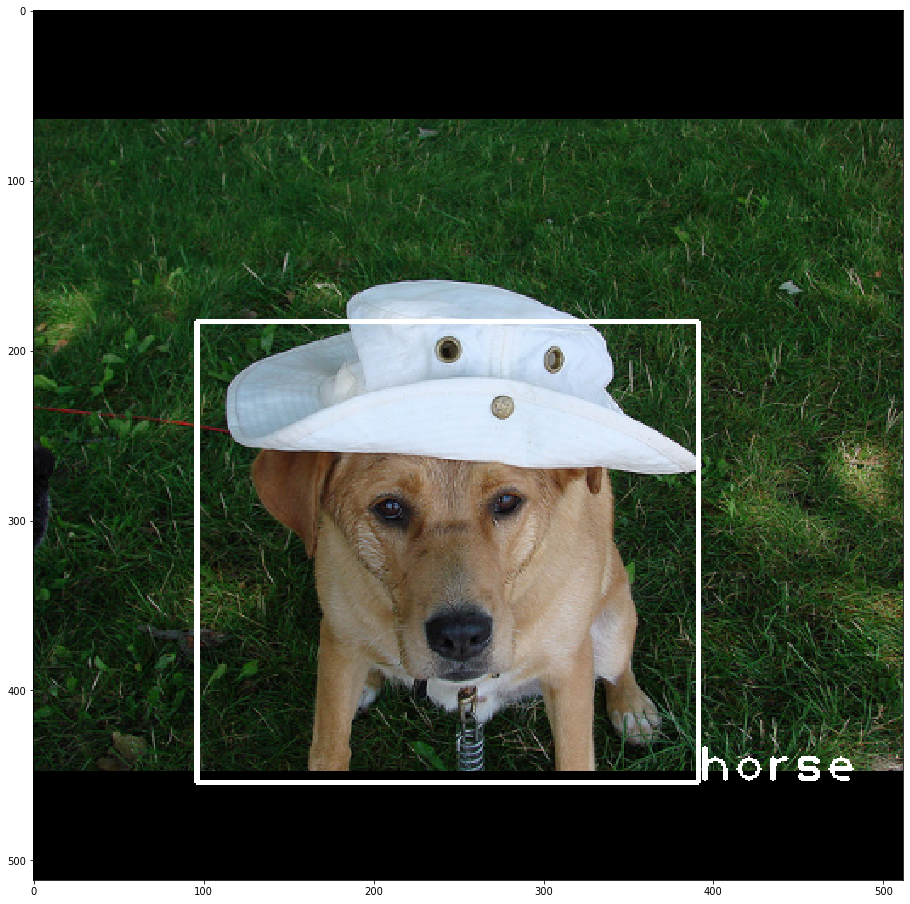

In [63]:
idx = 3

batch_images = batch_data[idx]['image']

batch_images = batch_data[idx]['image']
batch_base_loc = batch_data[idx]['base_loc']
batch_images.shape

cls_pred, loc_pred = model.predict(batch_images)

### Below cell Equivalent to  predict_box 

# equi of __init__
# num_classes = 10 + 1
bg_index = num_classes - 1




loc_base = batch_base_loc
cls_pred = tf.convert_to_tensor(cls_pred)
loc_pred = tf.convert_to_tensor(loc_pred)

input_width = WIDTH
input_height = HEIGHT
top_n = 300
score_threshold = 0.05
std = 0.2
mean = 0


anchor_w_h = tf.tile(loc_base[:, :, 2:], [1, 1, 2]) - tf.tile(loc_base[:, :, :2], [1, 1, 2])
anchorbox = loc_base
loc_pred_abs = tf.map_fn(lambda x: (x[0] * std + mean) * x[1] + x[2],
                             elems=(loc_pred, anchor_w_h, anchorbox),
                             dtype=tf.float32,
                             back_prop=False)
x1 = tf.clip_by_value(loc_pred_abs[:, :, 0], 0, input_width)
y1 = tf.clip_by_value(loc_pred_abs[:, :, 1], 0, input_height)
x2 = tf.clip_by_value(loc_pred_abs[:, :, 2], 0, input_width)
y2 = tf.clip_by_value(loc_pred_abs[:, :, 3], 0, input_height)
loc_pred_abs = tf.stack([x1, y1, x2, y2], axis=2)

num_batch, num_anchor, _ = loc_pred_abs.shape
cls_best_score = tf.reduce_max(cls_pred, axis=-1)
cls_best_class = tf.argmax(cls_pred, axis=-1)

cls_best_score = tf.where(tf.not_equal(cls_best_class, bg_index), cls_best_score, 0)

# select top n anchor boxes to proceed
# Padded Nonmax suppression with threshold
selected_indices_padded = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).selected_indices,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)

valid_outputs = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).valid_outputs,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
# return loc_pred_abs, selected_indices_padded, valid_outputs


cls_pred = cls_pred.numpy()
loc_pred_abs = loc_pred_abs.numpy()


# cls_pred pertains to batch, whereas ele_cls_pred pertains to an element of a batch

batch_idx = np.random.randint(0,16)
elem_selected_indices = selected_indices_padded[batch_idx]
elem_valid_outputs = valid_outputs[batch_idx]
elem_cls_pred = cls_pred[batch_idx]
elem_loc_pred_abs = loc_pred_abs[batch_idx]

indices = elem_selected_indices[:elem_valid_outputs] # indices into anchor boxes
indices = indices.numpy()

predicted_cls = elem_cls_pred[indices] 
predicted_cls = np.argmax(predicted_cls,-1)
predicted_bbox = elem_loc_pred_abs[indices]

predicted_cls

im = batch_images[batch_idx]
im = im.numpy()

fig = plt.figure(figsize=(16,16))
for bbox_index in range(len(predicted_bbox)):
    
    x1,y1,x2,y2 = predicted_bbox[bbox_index]
    cls = predicted_cls[bbox_index]
    cls = index2cat[cls]
    print(cls)
    cv2.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), 2)
    cv2.putText(im, cls, (int(x2), int(y2)), font, 2, (255,255,255),2,cv2.LINE_AA, False)
#     cv2.putText(im, cls, (int(x1)+1, int(y1)-14), font, 1, (255,255,0),9, cv2.LINE_AA, False)
    
plt.imshow(im)

In [31]:
index2cat = {
 0: 'bicycle',
 1: 'car',
 2: 'motorcycle',
 3: 'bus',
 4: 'train',
 5: 'truck',
 6: 'boat',
 7: 'bird',
 8: 'cat',
 9: 'dog',
 10: 'horse',
 11: 'sheep'}

{0:2, 1:3, 2:4 ,3:6 ,4:7,5:8,6:9,7:16,8:17,9:18,10:19,11:20 }


In [86]:
path = '/home/ubuntu/fastestimator/apphub/image_detection/retinanet_coco'
fp = os.path.join(path, 'val2014_bbox_results.json')
fp1 = os.path.join(path, 'bbox_result.json')

with open(fp,'r') as f:
    data = json.load(f)

old_tfms =      {0:1, 1:2, 2:3, 3:5, 4:6, 5:7, 6:8, 7:14, 8:15, 9:16, 10:17, 11:18}
category_tfms = {0:2, 1:3, 2:4 ,3:6 ,4:7, 5:8, 6:9, 7:16, 8:17, 9:18, 10:19, 11:20 }
the_tfms =      {1:2, 2:3, 3:4, 5:6, 6:7, 7:8, 8:9, 14:16, 15:17, 16:18, 17:19, 18:20 }

for dict_elem in data:
    val = dict_elem['category_id']
    dict_elem['category_id'] = the_tfms[val]

with open(fp1, 'w') as f:
    json.dump(data, f)

val_new = pd.read_csv('/home/ubuntu/coco/val_new.csv')

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

annFile='/home/ubuntu/coco/annotations/instances_val2014.json'
coco=COCO(annFile)


df = pd.read_csv('/home/ubuntu/coco/val_new.csv')
val_imgIds = df['image_id'].values
val_imgIds = [ int(elem) for elem in val_imgIds]



coco_pred = coco.loadRes('/home/ubuntu/fastestimator/apphub/image_detection/retinanet_coco/bbox_result.json')
# run COCO evaluation
coco_eval = COCOeval(coco, coco_pred, 'bbox')
coco_eval.params.imgIds = val_imgIds
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()




loading annotations into memory...
Done (t=4.49s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.77s).
Accumulating evaluation results...
DONE (t=0.78s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets